# Covid19

In [1]:
# Import all the libraries

# for data manipulation & linear algebrea
import pandas as pd
import numpy as np
pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 30)

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import plotly
# import plotly.graph_objs as go
%config InlineBackend.figure_format = 'retina' # vs 'svg'/'png'
plt.rcParams['figure.figsize'] = 15, 12
plt.rcParams['image.cmap'] = 'viridis'

# for machine learning
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# Other libraries
import time
from datetime import datetime
import sys

# Path
import sys
sys.path.append('/Users/herve/code/hervelao/covid19-global-forecasting')
# from pathlib import Path
# data_dir = Path('/Users/herve/code/hervelao/covid19-global-forecasting')

# Autoreload
%load_ext autoreload
%autoreload 2

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
from covid19.data import COVID19

data = COVID19().get_data()

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by -inf%
Memory usage of dataframe is 0.56 MB
Memory usage after optimization is: 0.14 MB
Decreased by 74.7%
Memory usage of dataframe is 0.28 MB
Memory usage after optimization is: 0.05 MB
Decreased by 83.3%
Memory usage of dataframe is 1.09 MB
Memory usage after optimization is: 0.31 MB
Decreased by 72.1%


## 1. Exploratory data analysis (EDA)

In [3]:
data.keys()

dict_keys(['.DS_S', 'test', 'submission', 'train'])

In [4]:
submission = data['submission']
test = data['test']
train = data['train']
display(train.head(5))
display(train.describe())
print("Number of Country/Region: ", train['Country/Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")
print("Countries with Province/State informed: ", train[train['Province/State'].isna()==False]['Country/Region'].unique())

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


,Id,Lat,Long,ConfirmedCases,Fatalities
count,17892.00,1.79e+04,1.79e+04,17892.00,17892.0
mean,13191.50,inf,inf,325.21,inf
std,7624.68,2.29e+01,7.99e+01,3538.00,inf
min,1.00,-4.15e+01,-1.58e+02,0.00,0.0
25%,6596.25,1.31e+01,-7.15e+01,0.00,0.0
50%,13191.50,3.30e+01,9.77e+00,0.00,0.0
75%,19786.75,4.25e+01,6.47e+01,10.00,0.0
max,26382.00,7.17e+01,1.75e+02,69176.00,6820.0


Number of Country/Region:  163
Dates go from day 2020-03-24 to day 2020-01-22 , a total of 63 days
Countries with Province/State informed:  [Australia, Canada, China, Cruise Ship, Denmark, France, Netherlands, US, United Kingdom]
Categories (9, object): [Australia, Canada, China, Cruise Ship, ..., France, Netherlands, US, United Kingdom]


Text(0.5, 0, 'Date')

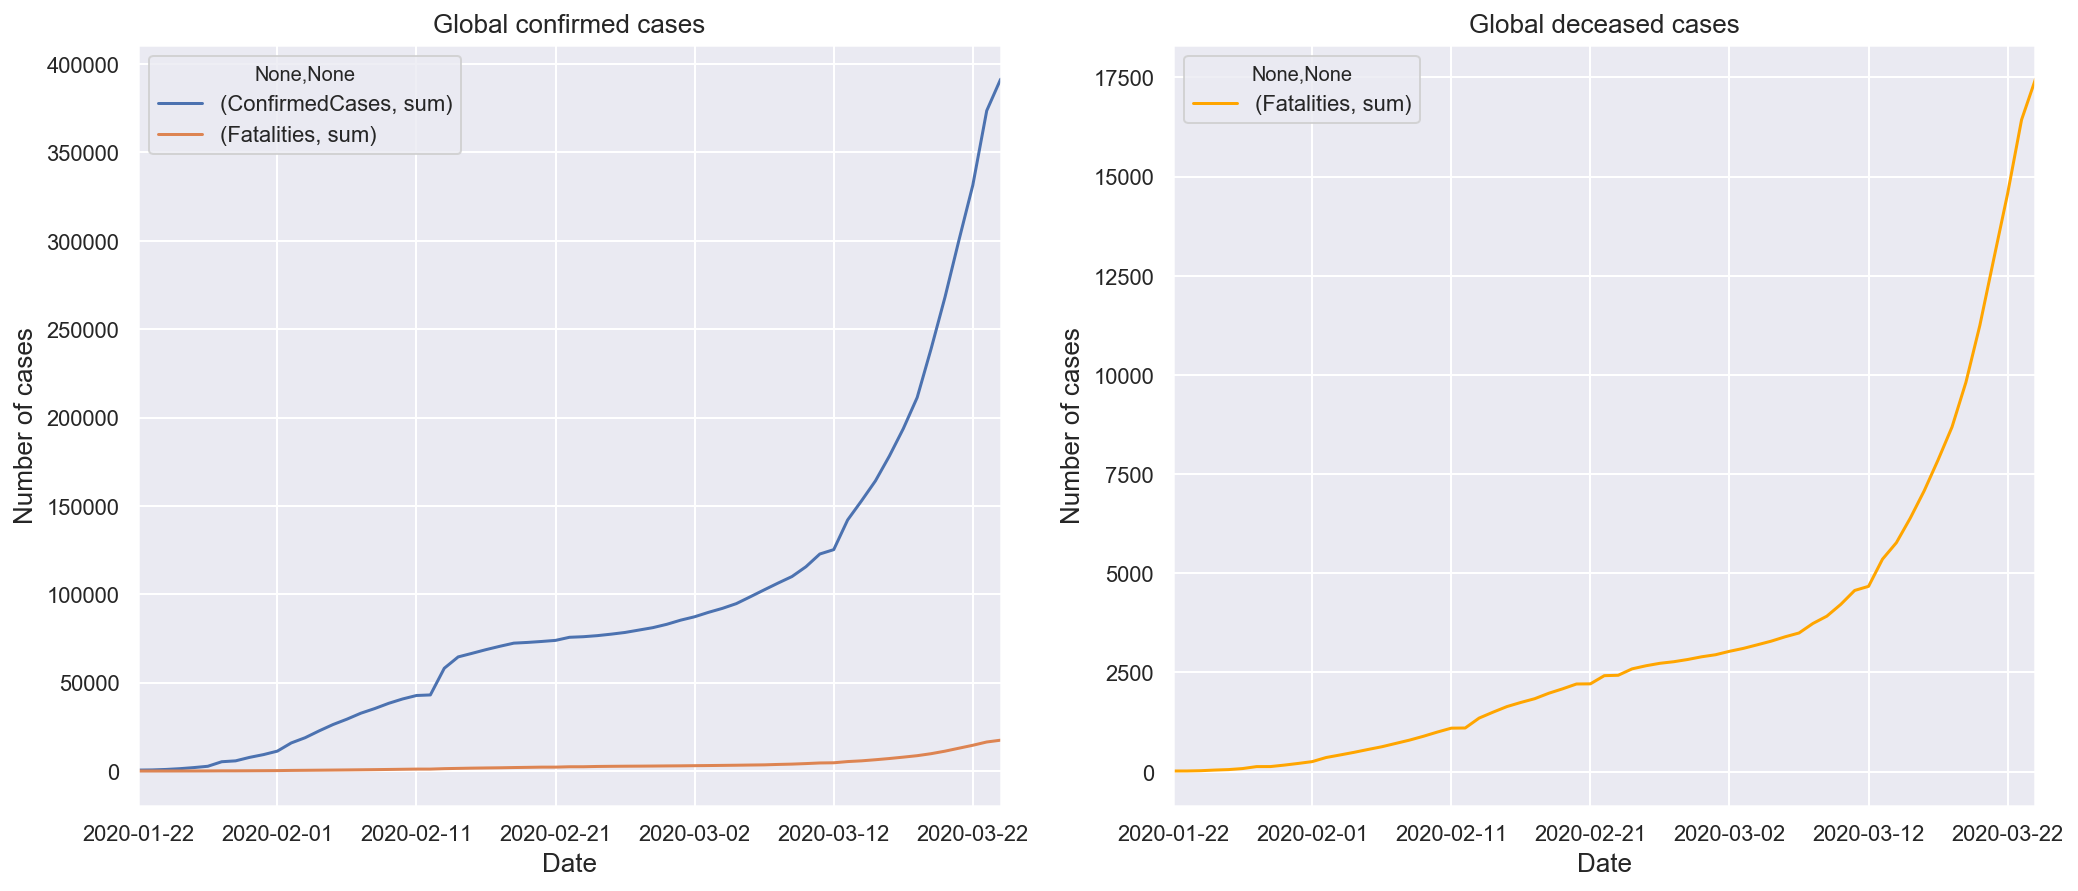

In [5]:
confirmed_country = train.groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country = train.groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))

total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

Text(0.5, 0, 'Date')

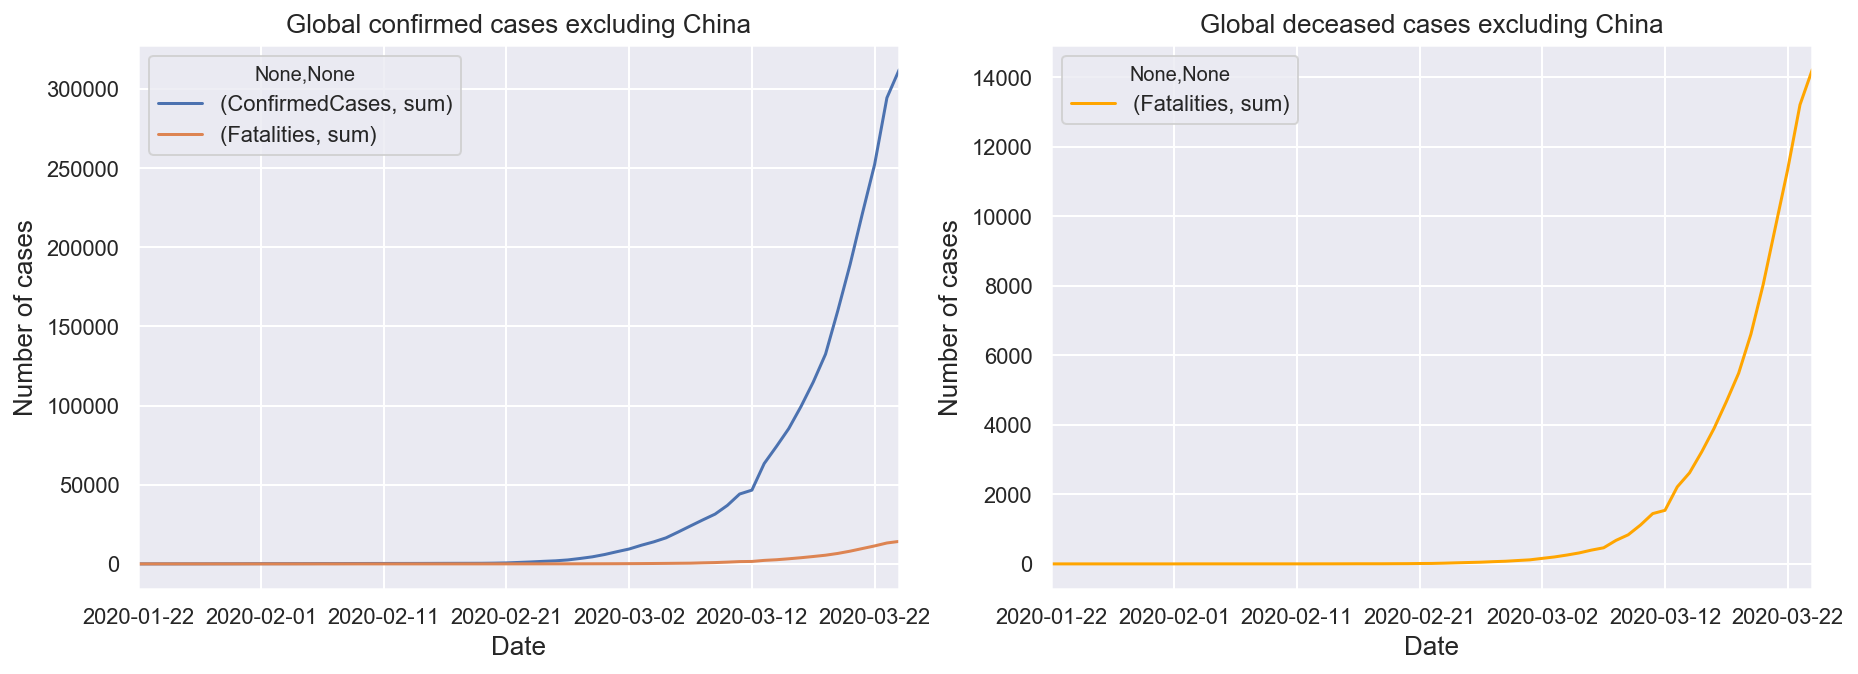

In [6]:
confirmed_country_noChina = train[train['Country/Region']!='China'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_noChina = train[train['Country/Region']!='China'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_noChina = train[train['Country/Region']!='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_noChina = train[train['Country/Region']!='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_noChina = confirmed_total_date_noChina.join(fatalities_total_date_noChina)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
total_date_noChina.plot(ax=ax1)
ax1.set_title("Global confirmed cases excluding China", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_noChina.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases excluding China", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

Text(0.5, 0, 'Date')

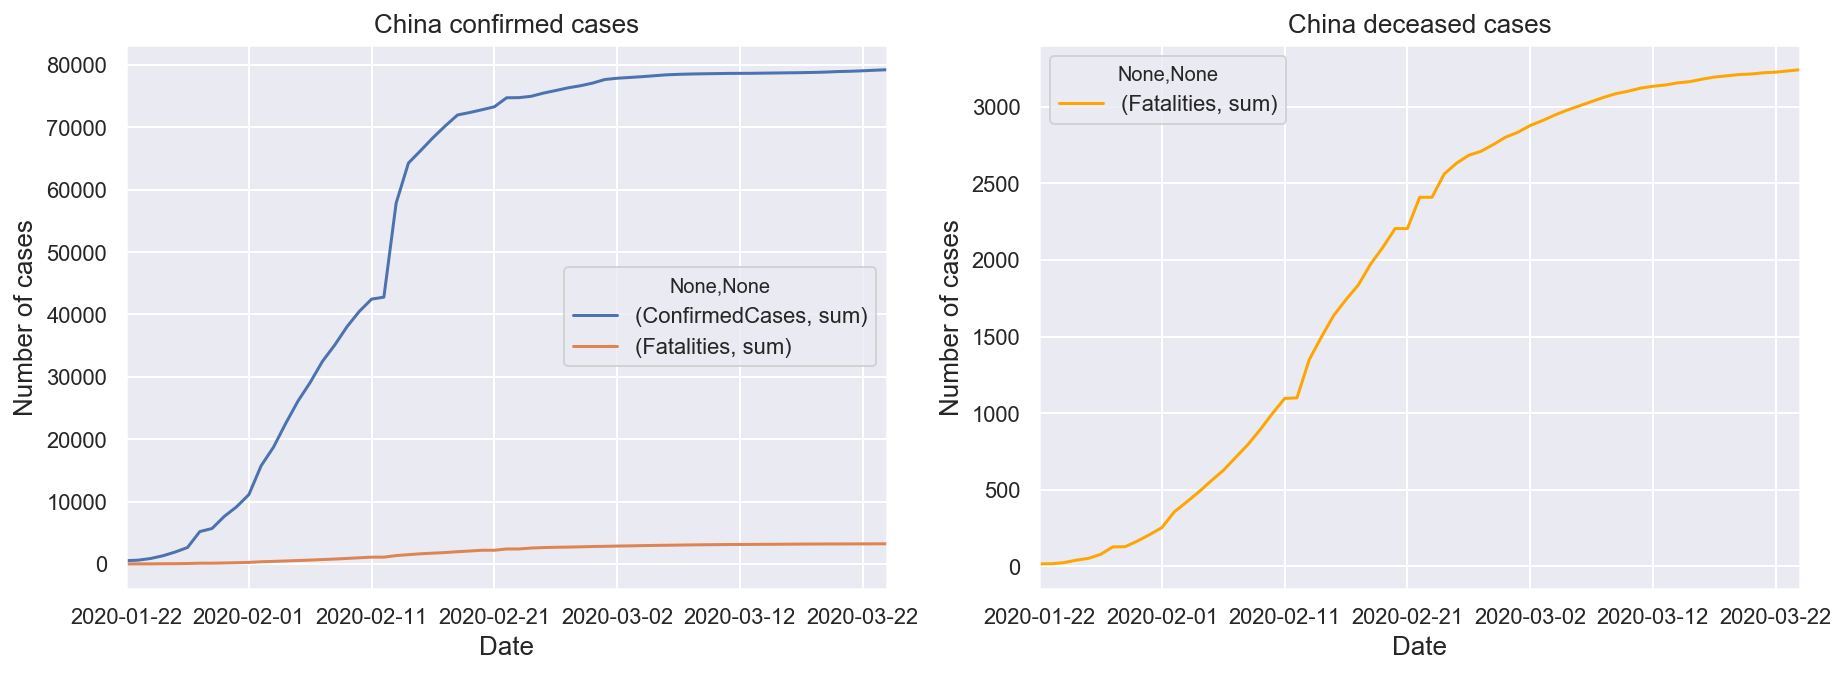

In [7]:
confirmed_country_China = train[train['Country/Region']=='China'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_China = train[train['Country/Region']=='China'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_China = train[train['Country/Region']=='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_China = train[train['Country/Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_China = confirmed_total_date_China.join(fatalities_total_date_China)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
total_date_China.plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_China.plot(ax=ax2, color='orange')
ax2.set_title("China deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

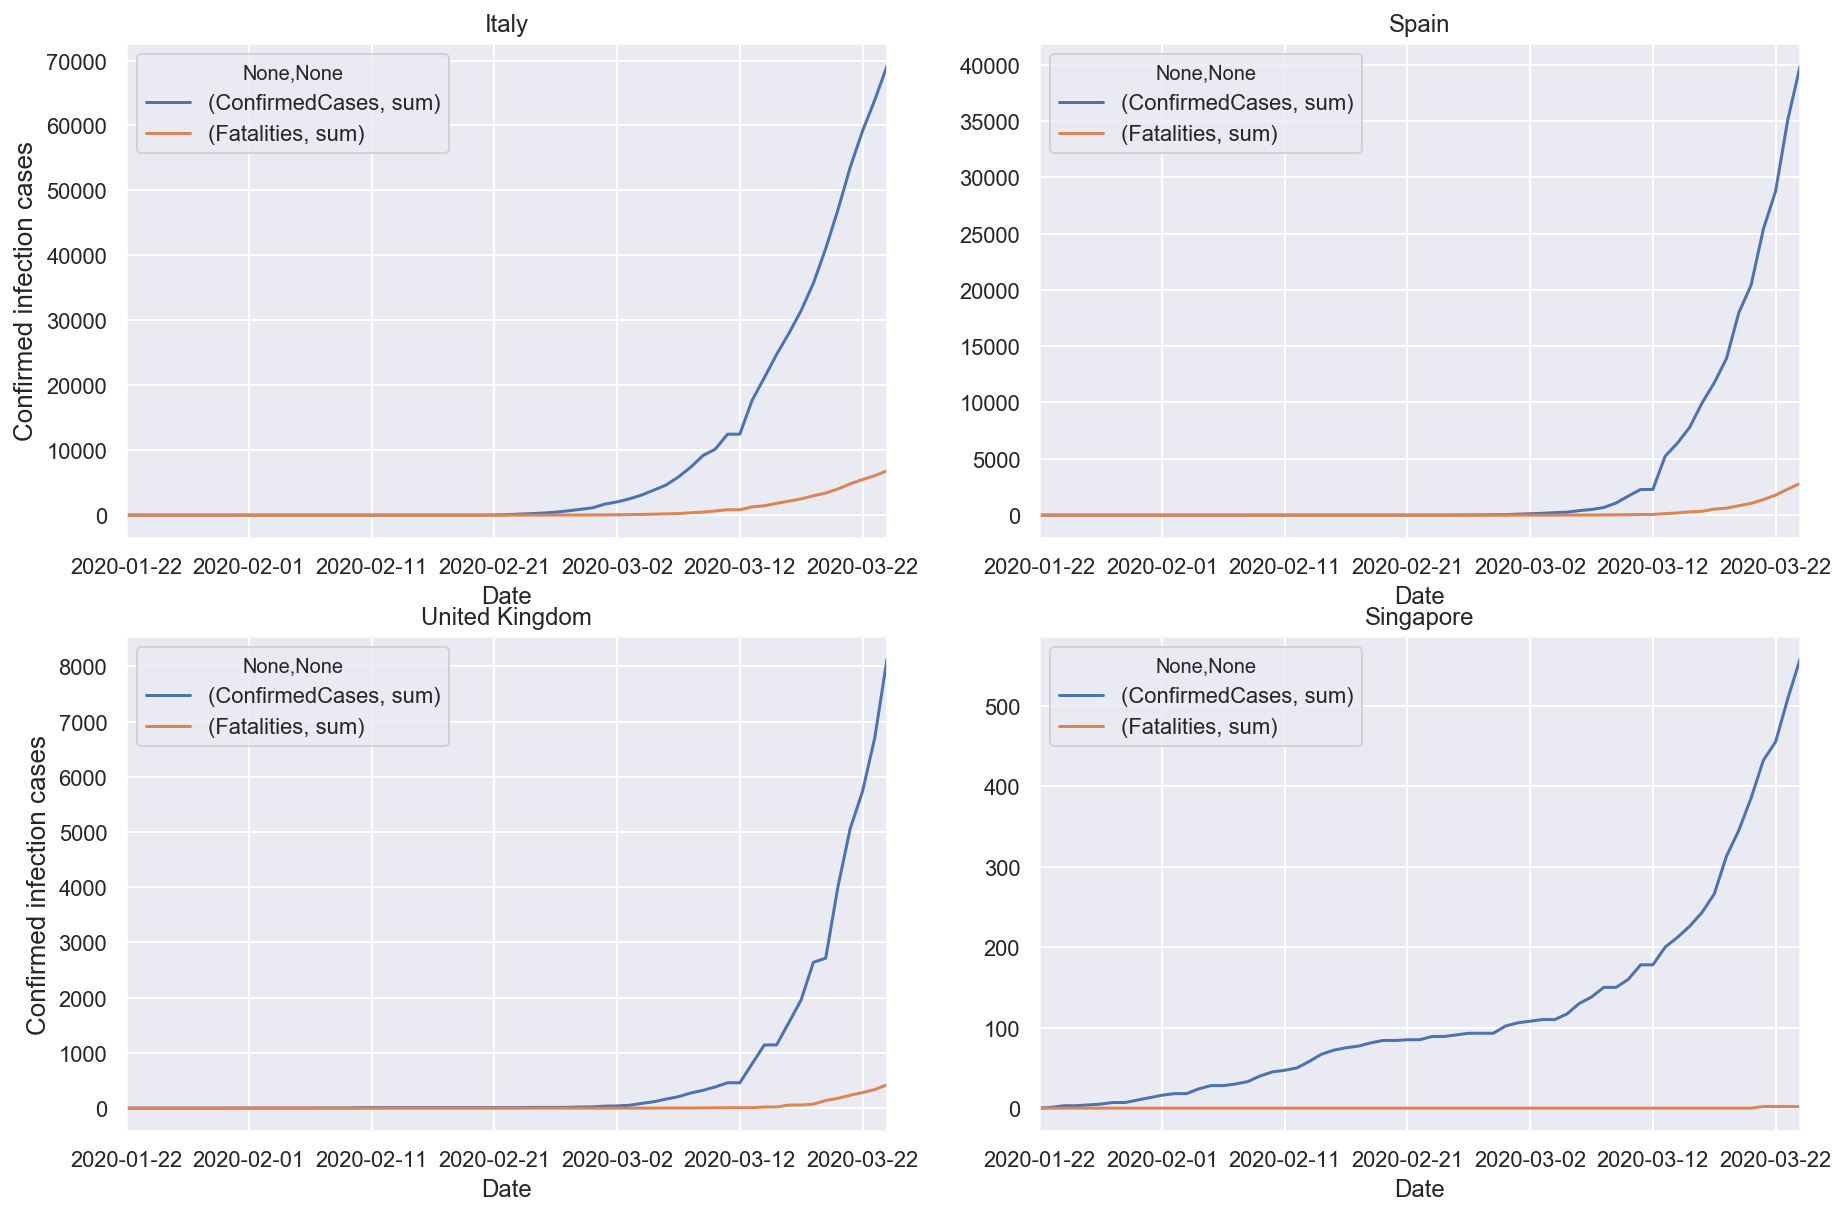

In [8]:
confirmed_country_Italy = train[train['Country/Region']=='Italy'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Italy = train[train['Country/Region']=='Italy'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Italy = train[train['Country/Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[train['Country/Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

confirmed_country_Spain = train[train['Country/Region']=='Spain'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Spain = train[train['Country/Region']=='Spain'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[train['Country/Region']=='Spain'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[train['Country/Region']=='Spain'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

confirmed_country_UK = train[train['Country/Region']=='United Kingdom'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_UK = train[train['Country/Region']=='United Kingdom'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[train['Country/Region']=='United Kingdom'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[train['Country/Region']=='United Kingdom'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

confirmed_country_Australia = train[train['Country/Region']=='Australia'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Australia = train[train['Country/Region']=='Australia'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[train['Country/Region']=='Australia'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[train['Country/Region']=='Australia'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

confirmed_country_Singapore = train[train['Country/Region']=='Singapore'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Singapore = train[train['Country/Region']=='Singapore'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[train['Country/Region']=='Singapore'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[train['Country/Region']=='Singapore'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 2)
total_date_Spain.plot(ax=plt.gca(), title='Spain')

plt.subplot(2, 2, 3)
total_date_UK.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 4)
total_date_Singapore.plot(ax=plt.gca(), title='Singapore')

(0, 0.005)

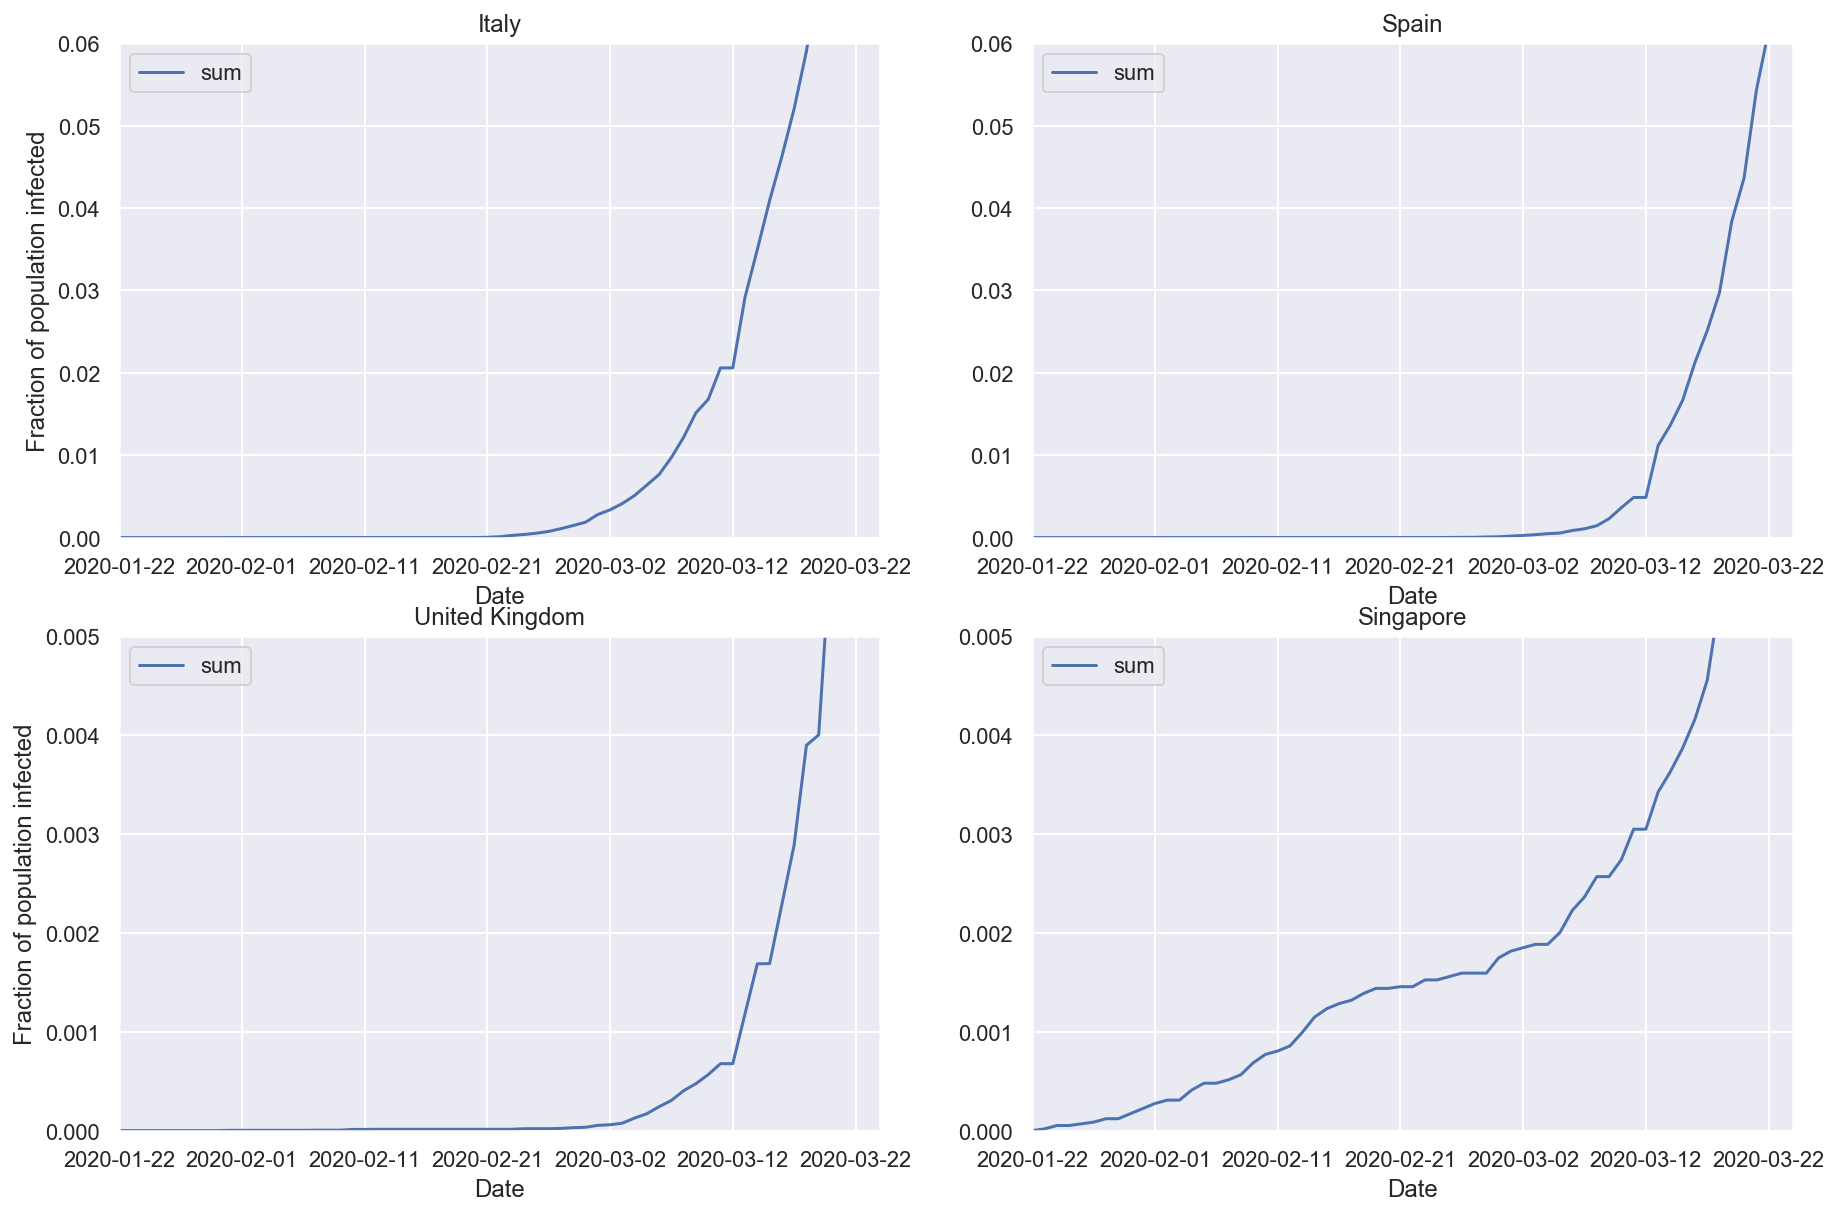

In [9]:
pop_italy = 60486683.
pop_spain = 46749696.
pop_UK = 67784927.
pop_singapore = 5837230.

total_date_Italy.ConfirmedCases = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Italy.Fatalities = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Spain.ConfirmedCases = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_Spain.Fatalities = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_UK.ConfirmedCases = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_UK.Fatalities = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_Singapore.ConfirmedCases = total_date_Singapore.ConfirmedCases/pop_singapore*100.
total_date_Singapore.Fatalities = total_date_Singapore.ConfirmedCases/pop_singapore*100.

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.ConfirmedCases.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.06)

plt.subplot(2, 2, 2)
total_date_Spain.ConfirmedCases.plot(ax=plt.gca(), title='Spain')
plt.ylim(0, 0.06)

plt.subplot(2, 2, 3)
total_date_UK.ConfirmedCases.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.005)

plt.subplot(2, 2, 4)
total_date_Singapore.ConfirmedCases.plot(ax=plt.gca(), title='Singapore')
plt.ylim(0, 0.005)

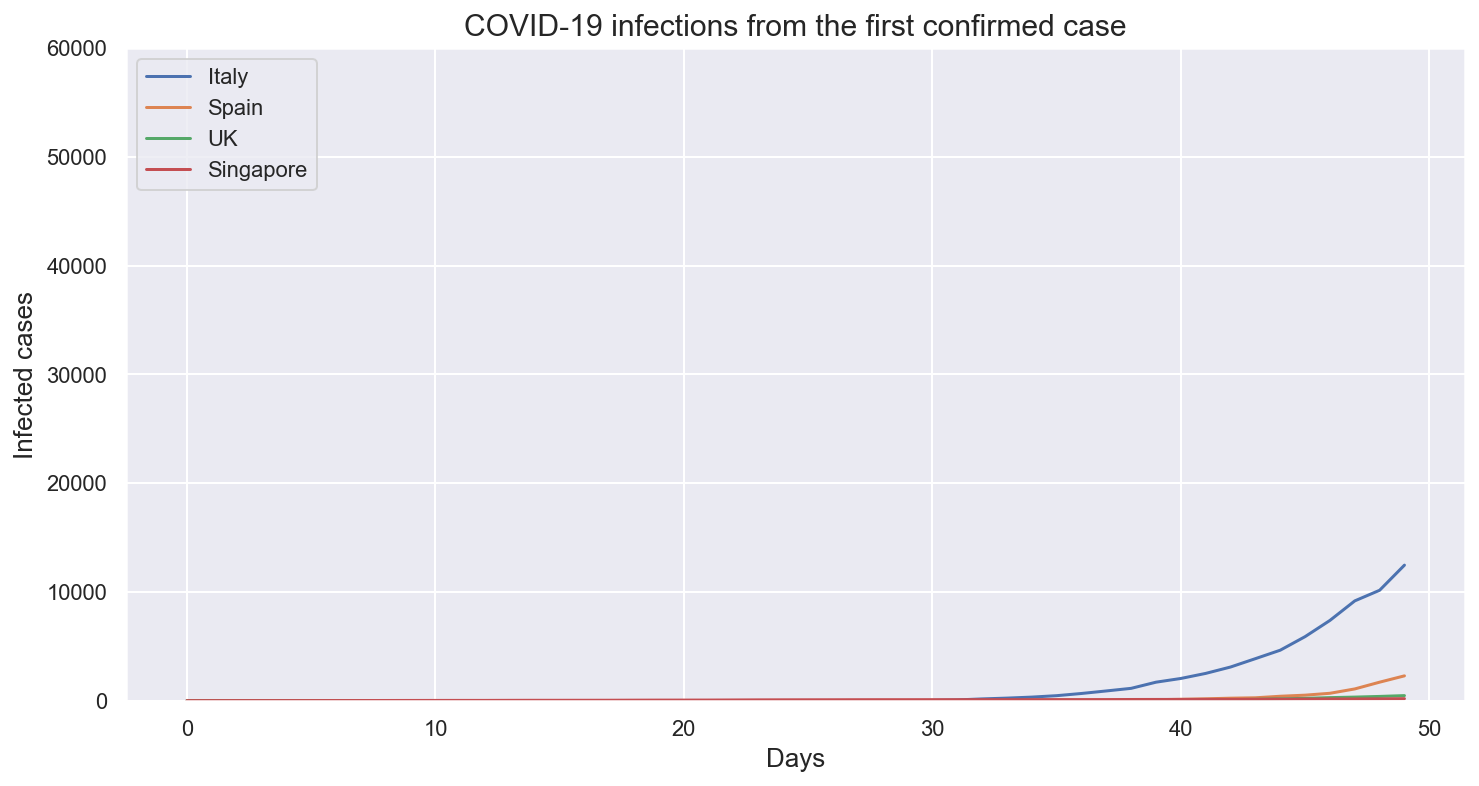

In [10]:
confirmed_country_Italy = train[(train['Country/Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Italy = train[(train['Country/Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Italy = train[(train['Country/Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[(train['Country/Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

confirmed_country_Spain = train[(train['Country/Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Spain = train[(train['Country/Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[(train['Country/Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[(train['Country/Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

confirmed_country_UK = train[(train['Country/Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_UK = train[(train['Country/Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[(train['Country/Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[(train['Country/Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

confirmed_country_Australia = train[(train['Country/Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Australia = train[(train['Country/Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[(train['Country/Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[(train['Country/Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

confirmed_country_Singapore = train[(train['Country/Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Singapore = train[(train['Country/Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[(train['Country/Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[(train['Country/Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

italy = [i for i in total_date_Italy.ConfirmedCases['sum'].values]
italy_30 = italy[0:50] 
spain = [i for i in total_date_Spain.ConfirmedCases['sum'].values]
spain_30 = spain[0:50] 
UK = [i for i in total_date_UK.ConfirmedCases['sum'].values]
UK_30 = UK[0:50] 
singapore = [i for i in total_date_Singapore.ConfirmedCases['sum'].values]
singapore_30 = singapore[0:50] 


# Plots
plt.figure(figsize=(12,6))
plt.plot(italy_30)
plt.plot(spain_30)
plt.plot(UK_30)
plt.plot(singapore_30)
plt.legend(["Italy", "Spain", "UK", "Singapore"], loc='upper left')
plt.title("COVID-19 infections from the first confirmed case", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)
plt.ylim(0, 60000)
plt.show()

## 2. Feature Engineering (FE)

In [11]:
# Merge train and test, exclude overlap
dates_overlap = ['2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23']
train2 = train.loc[~train['Date'].isin(dates_overlap)]
all_data = pd.concat([train2, test], axis = 0, sort=False)

# Double check that there are no informed ConfirmedCases and Fatalities after 2020-03-11
all_data.loc[all_data['Date'] >= '2020-03-12', 'ConfirmedCases'] = np.nan
all_data.loc[all_data['Date'] >= '2020-03-12', 'Fatalities'] = np.nan
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province/State'] = all_data['Province/State'].cat.add_categories('None')
all_data['Province/State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)

# Aruba has no Lat nor Long. Inform it manually
all_data.loc[all_data['Lat'].isna()==True, 'Lat'] = 12.510052
all_data.loc[all_data['Long'].isna()==True, 'Long'] = -70.009354

display(all_data)
display(all_data.loc[all_data['Date'] == '2020-03-12'])

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,1.0,None,Afghanistan,33.00,65.00,2020-01-22,0.0,0.0,-1.0,0,22,1,2020
1,2.0,None,Afghanistan,33.00,65.00,2020-01-23,0.0,0.0,-1.0,1,23,1,2020
2,3.0,None,Afghanistan,33.00,65.00,2020-01-24,0.0,0.0,-1.0,2,24,1,2020
3,4.0,None,Afghanistan,33.00,65.00,2020-01-25,0.0,0.0,-1.0,3,25,1,2020
4,5.0,None,Afghanistan,33.00,65.00,2020-01-26,0.0,0.0,-1.0,4,26,1,2020
5,6.0,None,Afghanistan,33.00,65.00,2020-01-27,0.0,0.0,-1.0,5,27,1,2020
6,7.0,None,Afghanistan,33.00,65.00,2020-01-28,0.0,0.0,-1.0,6,28,1,2020
7,8.0,None,Afghanistan,33.00,65.00,2020-01-29,0.0,0.0,-1.0,7,29,1,2020
8,9.0,None,Afghanistan,33.00,65.00,2020-01-30,0.0,0.0,-1.0,8,30,1,2020
9,10.0,None,Afghanistan,33.00,65.00,2020-01-31,0.0,0.0,-1.0,9,31,1,2020


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,-1.0,None,Afghanistan,33.00,65.00,2020-03-12,0.0,0.0,1.0,50,12,3,2020
43,-1.0,None,Albania,41.16,20.17,2020-03-12,0.0,0.0,44.0,50,12,3,2020
86,-1.0,None,Algeria,28.03,1.66,2020-03-12,0.0,0.0,87.0,50,12,3,2020
129,-1.0,None,Andorra,42.50,1.52,2020-03-12,0.0,0.0,130.0,50,12,3,2020
172,-1.0,None,Antigua and Barbuda,17.06,-61.78,2020-03-12,0.0,0.0,173.0,50,12,3,2020
215,-1.0,None,Argentina,-38.41,-63.62,2020-03-12,0.0,0.0,216.0,50,12,3,2020
258,-1.0,None,Armenia,40.06,45.03,2020-03-12,0.0,0.0,259.0,50,12,3,2020
301,-1.0,None,Aruba,12.52,-69.94,2020-03-12,0.0,0.0,302.0,50,12,3,2020
344,-1.0,Australian Capital Territory,Australia,-35.47,149.00,2020-03-12,0.0,0.0,345.0,50,12,3,2020
387,-1.0,From Diamond Princess,Australia,35.44,139.62,2020-03-12,0.0,0.0,388.0,50,12,3,2020


In [12]:
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                0
Id              0
Province/State  0
Country/Region  0
Lat             0
Long            0
Date            0
ConfirmedCases  0
Fatalities      0
ForecastId      0
Day_num         0
Day             0
Month           0
Year            0


In [13]:
def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df[column]-df[column].shift(lag, fill_value=-999))/df[column].shift(lag, fill_value=0)
    return df


def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df[column].shift(lag, fill_value=0)
    return df

In [14]:
ts = time.time()
all_data = calculate_lag(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  0.26382994651794434


In [15]:
all_data.head(3)

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,ConfirmedCases_4,ConfirmedCases_5,ConfirmedCases_6,Fatalities_1,Fatalities_2,Fatalities_3,Fatalities_4,Fatalities_5,Fatalities_6,Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_Fatalities_1,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6
0,1.0,None,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,-1.0,0,22,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,None,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,-1.0,1,23,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,None,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,-1.0,2,24,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Load countries data file
world_population = pd.read_csv("../data/additional_csv/population_by_country_2020.csv")

In [17]:
# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

In [18]:
# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

In [19]:
# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

In [20]:
# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

print("Cleaned country details dataset")
display(world_population)

Cleaned country details dataset


,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1439323776,153,9388211,38,61
1,India,1380004385,464,2973190,28,35
2,US,331002651,36,9147420,38,83
3,Indonesia,273523615,151,1811570,30,56
4,Pakistan,220892340,287,770880,23,35
5,Brazil,212559417,25,8358140,33,88
6,Nigeria,206139589,226,910770,18,52
7,Bangladesh,164689383,1265,130170,28,39
8,Russia,145934462,9,16376870,40,74
9,Mexico,128932753,66,1943950,29,84


In [21]:
# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities
print("Joined dataset")
all_data = all_data.merge(world_population, left_on='Country/Region', right_on='Country (or dependency)', how='left')
all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)
display(all_data)
print("Encoded dataset")

Joined dataset


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,ConfirmedCases_4,ConfirmedCases_5,ConfirmedCases_6,Fatalities_1,Fatalities_2,Fatalities_3,Fatalities_4,Fatalities_5,Fatalities_6,Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_Fatalities_1,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,1.0,None,Afghanistan,33.00,65.00,2020-01-22,0.0,0.0,-1.0,0,22,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,3.89e+07,60.0,652860.0,18.0,25.0
1,2.0,None,Afghanistan,33.00,65.00,2020-01-23,0.0,0.0,-1.0,1,23,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,3.89e+07,60.0,652860.0,18.0,25.0
2,3.0,None,Afghanistan,33.00,65.00,2020-01-24,0.0,0.0,-1.0,2,24,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,3.89e+07,60.0,652860.0,18.0,25.0
3,4.0,None,Afghanistan,33.00,65.00,2020-01-25,0.0,0.0,-1.0,3,25,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,3.89e+07,60.0,652860.0,18.0,25.0
4,5.0,None,Afghanistan,33.00,65.00,2020-01-26,0.0,0.0,-1.0,4,26,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,3.89e+07,60.0,652860.0,18.0,25.0
5,6.0,None,Afghanistan,33.00,65.00,2020-01-27,0.0,0.0,-1.0,5,27,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,3.89e+07,60.0,652860.0,18.0,25.0
6,7.0,None,Afghanistan,33.00,65.00,2020-01-28,0.0,0.0,-1.0,6,28,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,3.89e+07,60.0,652860.0,18.0,25.0
7,8.0,None,Afghanistan,33.00,65.00,2020-01-29,0.0,0.0,-1.0,7,29,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,3.89e+07,60.0,652860.0,18.0,25.0
8,9.0,None,Afghanistan,33.00,65.00,2020-01-30,0.0,0.0,-1.0,8,30,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,3.89e+07,60.0,652860.0,18.0,25.0
9,10.0,None,Afghanistan,33.00,65.00,2020-01-31,0.0,0.0,-1.0,9,31,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,3.89e+07,60.0,652860.0,18.0,25.0


Encoded dataset


In [22]:
# Label encode countries and provinces. Save dictionary for exploration purposes
all_data.drop('Country (or dependency)', inplace=True, axis=1)
all_data['Country/Region'] = le.fit_transform(all_data['Country/Region'])
number_c = all_data['Country/Region']
countries = le.inverse_transform(all_data['Country/Region'])
country_dict = dict(zip(countries, number_c)) 
all_data['Province/State'] = le.fit_transform(all_data['Province/State'])
number_p = all_data['Province/State']
province = le.inverse_transform(all_data['Province/State'])
province_dict = dict(zip(province, number_p)) 
display(all_data)

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,ConfirmedCases_4,ConfirmedCases_5,ConfirmedCases_6,Fatalities_1,Fatalities_2,Fatalities_3,Fatalities_4,Fatalities_5,Fatalities_6,Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_Fatalities_1,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
0,1.0,80,0,33.00,65.00,2020-01-22,0.0,0.0,-1.0,0,22,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.89e+07,60.0,652860.0,18.0,25.0
1,2.0,80,0,33.00,65.00,2020-01-23,0.0,0.0,-1.0,1,23,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.89e+07,60.0,652860.0,18.0,25.0
2,3.0,80,0,33.00,65.00,2020-01-24,0.0,0.0,-1.0,2,24,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.89e+07,60.0,652860.0,18.0,25.0
3,4.0,80,0,33.00,65.00,2020-01-25,0.0,0.0,-1.0,3,25,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.89e+07,60.0,652860.0,18.0,25.0
4,5.0,80,0,33.00,65.00,2020-01-26,0.0,0.0,-1.0,4,26,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.89e+07,60.0,652860.0,18.0,25.0
5,6.0,80,0,33.00,65.00,2020-01-27,0.0,0.0,-1.0,5,27,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.89e+07,60.0,652860.0,18.0,25.0
6,7.0,80,0,33.00,65.00,2020-01-28,0.0,0.0,-1.0,6,28,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.89e+07,60.0,652860.0,18.0,25.0
7,8.0,80,0,33.00,65.00,2020-01-29,0.0,0.0,-1.0,7,29,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.89e+07,60.0,652860.0,18.0,25.0
8,9.0,80,0,33.00,65.00,2020-01-30,0.0,0.0,-1.0,8,30,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.89e+07,60.0,652860.0,18.0,25.0
9,10.0,80,0,33.00,65.00,2020-01-31,0.0,0.0,-1.0,9,31,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.89e+07,60.0,652860.0,18.0,25.0


## Predictions

### Predictions for 1 country

Text(0, 0.5, 'Log ConfirmedCases')

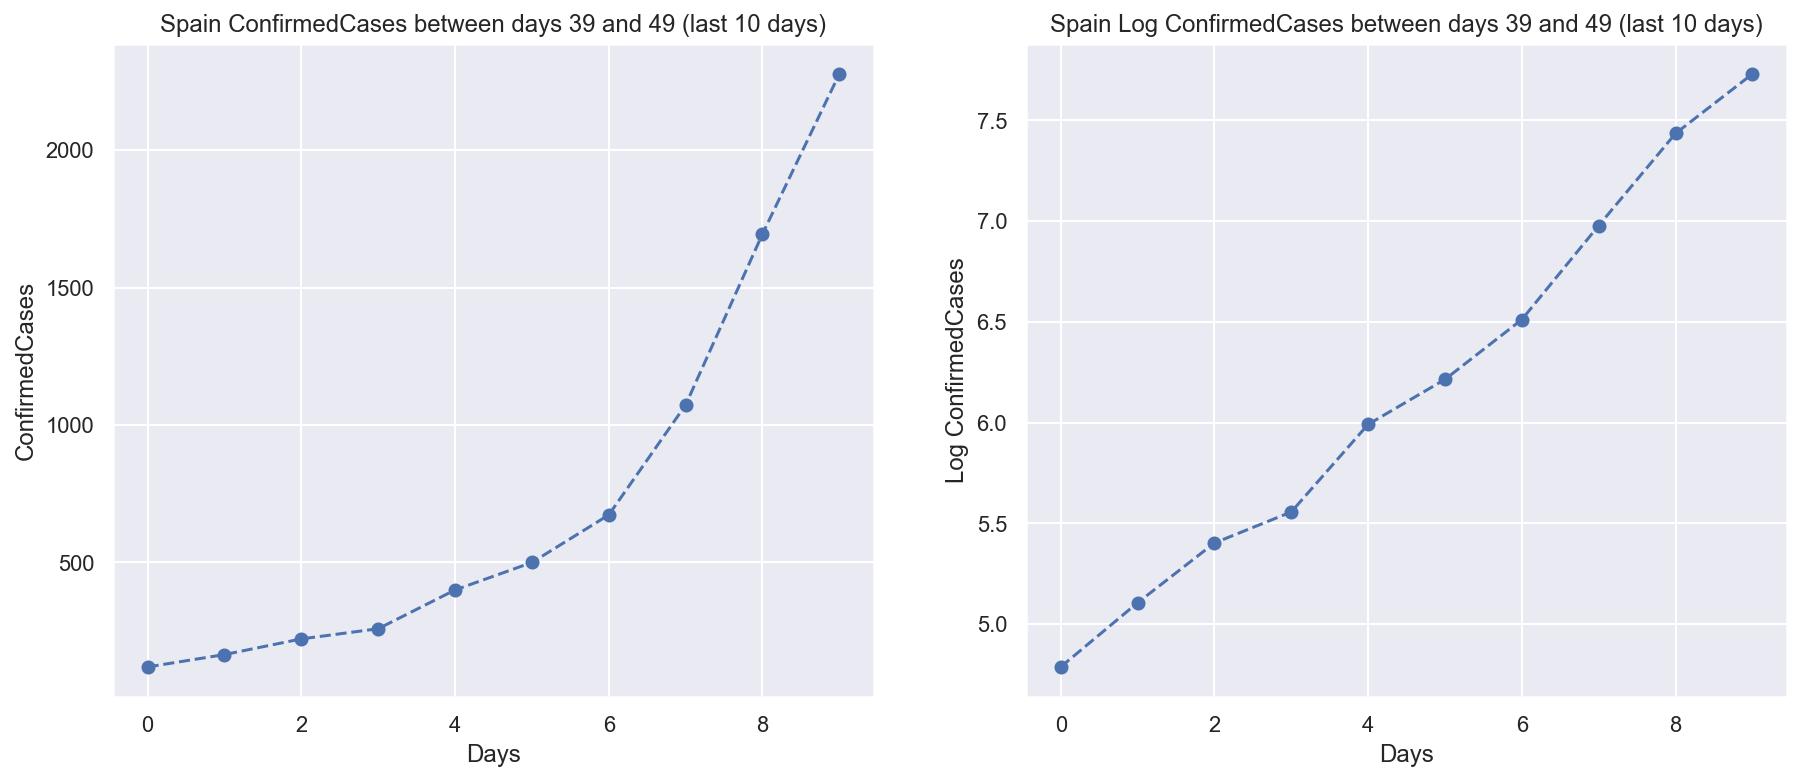

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Day_num = 38 is March 1st
y1 = all_data[(all_data['Lat']==40.0) & (all_data['Long']==-4.0) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("Spain ConfirmedCases between days 39 and 49 (last 10 days)")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

y2 = all_data[(all_data['Lat']==40.0) & (all_data['Long']==-4.0) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("Spain Log ConfirmedCases between days 39 and 49 (last 10 days)")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log ConfirmedCases")

In [24]:
# Filter selected features
data = all_data.copy()
features = ['Id', 'ForecastId', 'Country/Region', 'Province/State', 'ConfirmedCases', 'Fatalities', 
       'Day_num', 'Day', 'Month', 'Year', 'Long', 'Lat']
data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)

In [25]:
# Split data into train/test
def split_data(data):
    
    # Train set
    x_train = data[data.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = data[data.ForecastId == -1]['ConfirmedCases']
    y_train_2 = data[data.ForecastId == -1]['Fatalities']

    # Test set
    x_test = data[data.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


# Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred


# Submission function
def get_submission(df):
    
    prediction_1 = df['Predicted_ConfirmedCases']
    prediction_2 = df['Predicted_Fatalities']

    # Submit predictions
    prediction_1 = [int(item) for item in list(map(round, prediction_1))]
    prediction_2 = [int(item) for item in list(map(round, prediction_2))]
    
    submission = pd.DataFrame({
        "ForecastId": df['ForecastId'].astype('int32'), 
        "ConfirmedCases": prediction_1, 
        "Fatalities": prediction_2
    })
    submission.to_csv('submission.csv', index=False)

In [26]:
# Manually fixing a weird bug on my code on day 62
data = data.loc[~((data['Id'] != -1) & (data['Day_num'] > 49))]

In [27]:
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
day_start = 39
data_country = data[data['Country/Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

In [28]:
# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

In [29]:
# Select train (real) data from March 1 to March 22nd
dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', 
                 '2020-03-10', '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23']

# Select predictions from March 1st to March 22nd
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

In [30]:
predicted_data

10188     4.43
10189     4.79
10190     5.11
10191     5.40
10192     5.56
10193     5.99
10194     6.21
10195     6.51
10196     6.98
10197     7.44
10198     7.73
23041     7.95
23042     8.28
23043     8.60
23044     8.92
23045     9.25
23046     9.57
23047     9.90
23048    10.22
23049    10.54
23050    10.87
23051    11.19
23052    11.51
Name: Target, dtype: float64

Text(0.5, 0.98, 'ConfirmedCases predictions based on Logistic Regression for Spain')

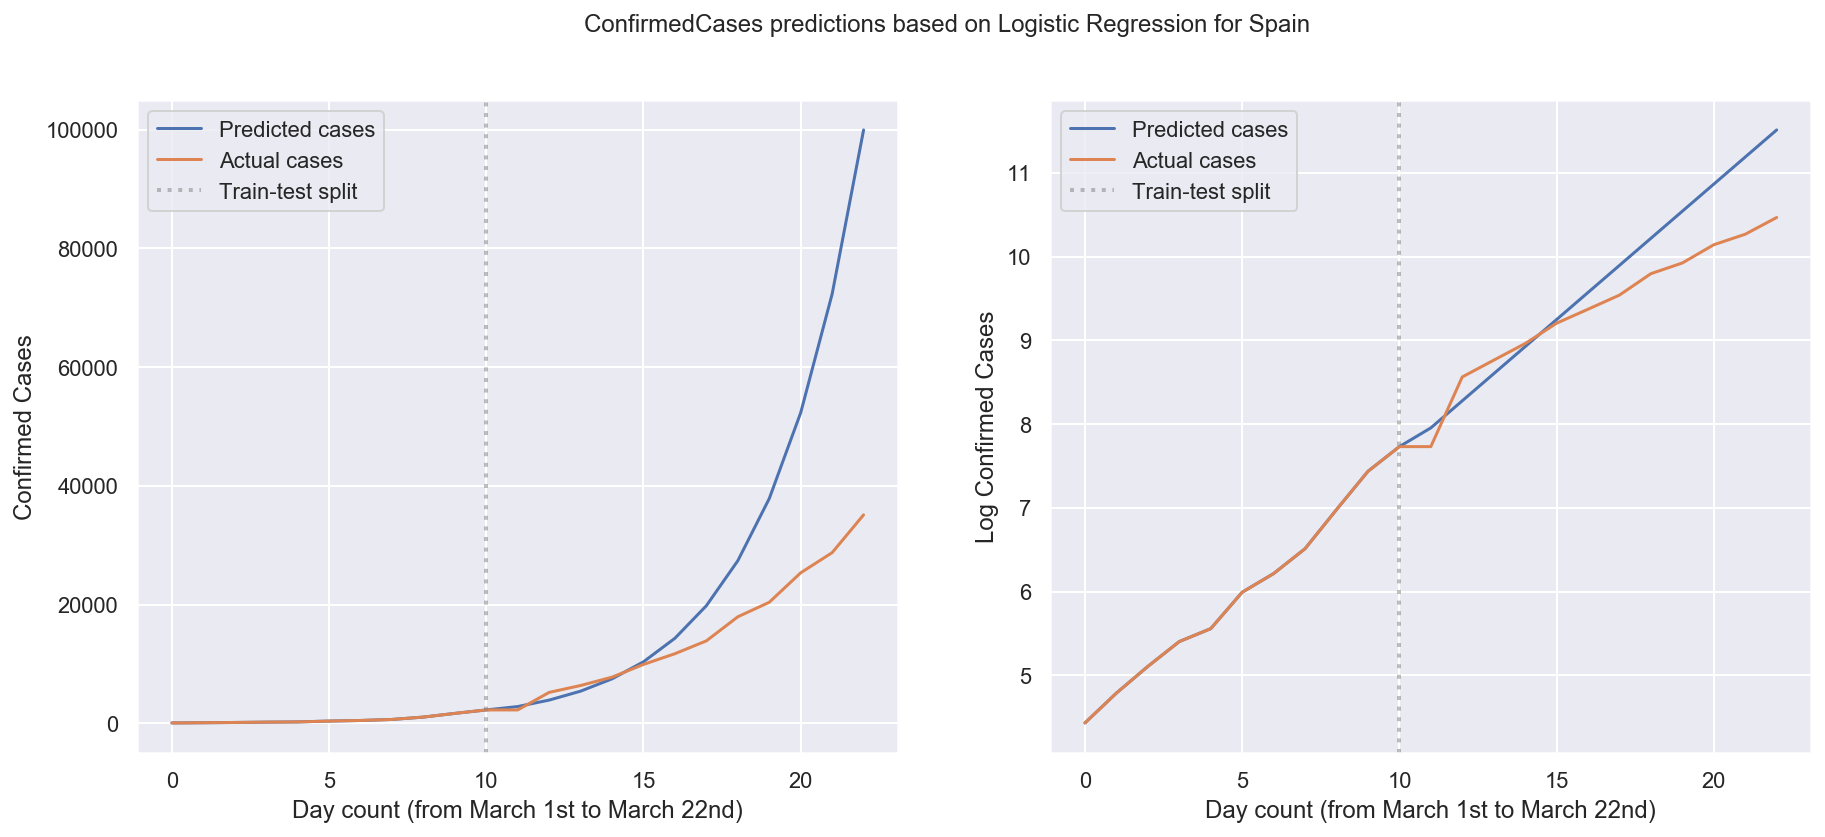

In [31]:
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 22nd)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 22nd)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Logistic Regression for "+country_name))

### Logistic Regression for all countries

In [32]:
ts = time.time()

day_start = 39
data2 = data.loc[data.Day_num >= day_start]

# Set the dataframe where we will update the predictions
data_pred = data[data.ForecastId != -1][['Country/Region', 'Province/State', 'Day_num', 'ForecastId']]
data_pred = data_pred.loc[data_pred['Day_num']>=day_start]
data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
data_pred['Predicted_Fatalities'] = [0]*len(data_pred)
    
print("Currently running Logistic Regression for all countries")

# Main loop for countries
for c in data2['Country/Region'].unique():
    
    # List of provinces
    provinces_list = data2[data2['Country/Region']==c]['Province/State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        for p in provinces_list:
            data_cp = data2[(data2['Country/Region']==c) & (data2['Province/State']==p)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred.loc[((data_pred['Country/Region']==c) & (data2['Province/State']==p)), 'Predicted_ConfirmedCases'] = pred_1
            data_pred.loc[((data_pred['Country/Region']==c) & (data2['Province/State']==p)), 'Predicted_Fatalities'] = pred_2

    # No Province/State informed
    else:
        data_c = data2[(data2['Country/Region']==c)]
        X_train, Y_train_1, Y_train_2, X_test = split_data(data_c)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data_pred.loc[(data_pred['Country/Region']==c), 'Predicted_ConfirmedCases'] = pred_1
        data_pred.loc[(data_pred['Country/Region']==c), 'Predicted_Fatalities'] = pred_2

# Aplly exponential transf. and clean potential infinites due to final numerical precision
data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.exp(x))
data_pred.replace([np.inf, -np.inf], 0, inplace=True) 

get_submission(data_pred)

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Currently running Logistic Regression for all countries
Process finished in  7.91  seconds


Below if we keep all data for each country

In [33]:
ts = time.time()

# Set the dataframe where we will update the predictions
data_pred = data[data.ForecastId != -1][['Country/Region', 'Province/State', 'Day_num', 'ForecastId']]
data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
data_pred['Predicted_Fatalities'] = [0]*len(data_pred)
how_many_days = test.Date.nunique()
    
print("Currently running Logistic Regression for all countries")

# Main loop for countries
for c in data['Country/Region'].unique():
    
    # List of provinces
    provinces_list = data2[data2['Country/Region']==c]['Province/State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        
        for p in provinces_list:
            # Only fit starting from the first confirmed case in the country
            train_countries_no0 = data.loc[(data['Country/Region']==c) & (data['Province/State']==p) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
            test_countries_no0 = data.loc[(data['Country/Region']==c) & (data['Province/State']==p) &  (data.ForecastId!=-1)]
            data2 = pd.concat([train_countries_no0, test_countries_no0])

            # If there are no previous cases, predict 0
            if len(train_countries_no0) == 0:
                data_pred.loc[((data_pred['Country/Region']==c) & (data_pred['Province/State']==p)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
                data_pred.loc[((data_pred['Country/Region']==c) & (data_pred['Province/State']==p)), 'Predicted_Fatalities'] = [0]*how_many_days
                
            # Else run LinReg
            else: 
                data_cp = data2[(data2['Country/Region']==c) & (data2['Province/State']==p)]
                X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp)
                model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
                model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
                data_pred.loc[((data_pred['Country/Region']==c) & (data2['Province/State']==p)), 'Predicted_ConfirmedCases'] = pred_1
                data_pred.loc[((data_pred['Country/Region']==c) & (data2['Province/State']==p)), 'Predicted_Fatalities'] = pred_2

    # No Province/State informed
    else:
        # Only fit starting from the first confirmed case in the country
        train_countries_no0 = data.loc[(data['Country/Region']==c) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
        test_countries_no0 = data.loc[(data['Country/Region']==c) &  (data.ForecastId!=-1)]
        data2 = pd.concat([train_countries_no0, test_countries_no0])

        # If there are no previous cases, predict 0
        if len(train_countries_no0) == 0:
            data_pred.loc[((data_pred['Country/Region']==c)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
            data_pred.loc[((data_pred['Country/Region']==c)), 'Predicted_Fatalities'] = [0]*how_many_days
        
        # Else, run LinReg
        else:
            data_c = data2[(data2['Country/Region']==c)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_c)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred.loc[(data_pred['Country/Region']==c), 'Predicted_ConfirmedCases'] = pred_1
            data_pred.loc[(data_pred['Country/Region']==c), 'Predicted_Fatalities'] = pred_2

# Aplly exponential transf. and clean potential infinites due to final numerical precision
data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.exp(x))
data_pred.replace([np.inf, -np.inf], 0, inplace=True) 

#get_submission(index, data_pred)

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Currently running Logistic Regression for all countries
Process finished in  3.32  seconds


### Logistic regression with lags

In [34]:
# New split function, for one forecast day
def split_data_one_day(data, d):
    
    #Train
    x_train = data[data.Day_num<d]
    y_train_1 = x_train.ConfirmedCases
    y_train_2 = x_train.Fatalities
    x_train.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    #Test
    x_test = data[data.Day_num==d]
    x_test.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


def plot_real_vs_prediction_country(data, train, country_name, day_start, dates_list):

    day_start = 39
    # Select predictions from March 1st to March 22nd
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].ConfirmedCases
    real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.exp(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March 1st)")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log(real_data))
    ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March 1st)")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Logistic Regression for "+country_name))

Process finished in  18.35  seconds


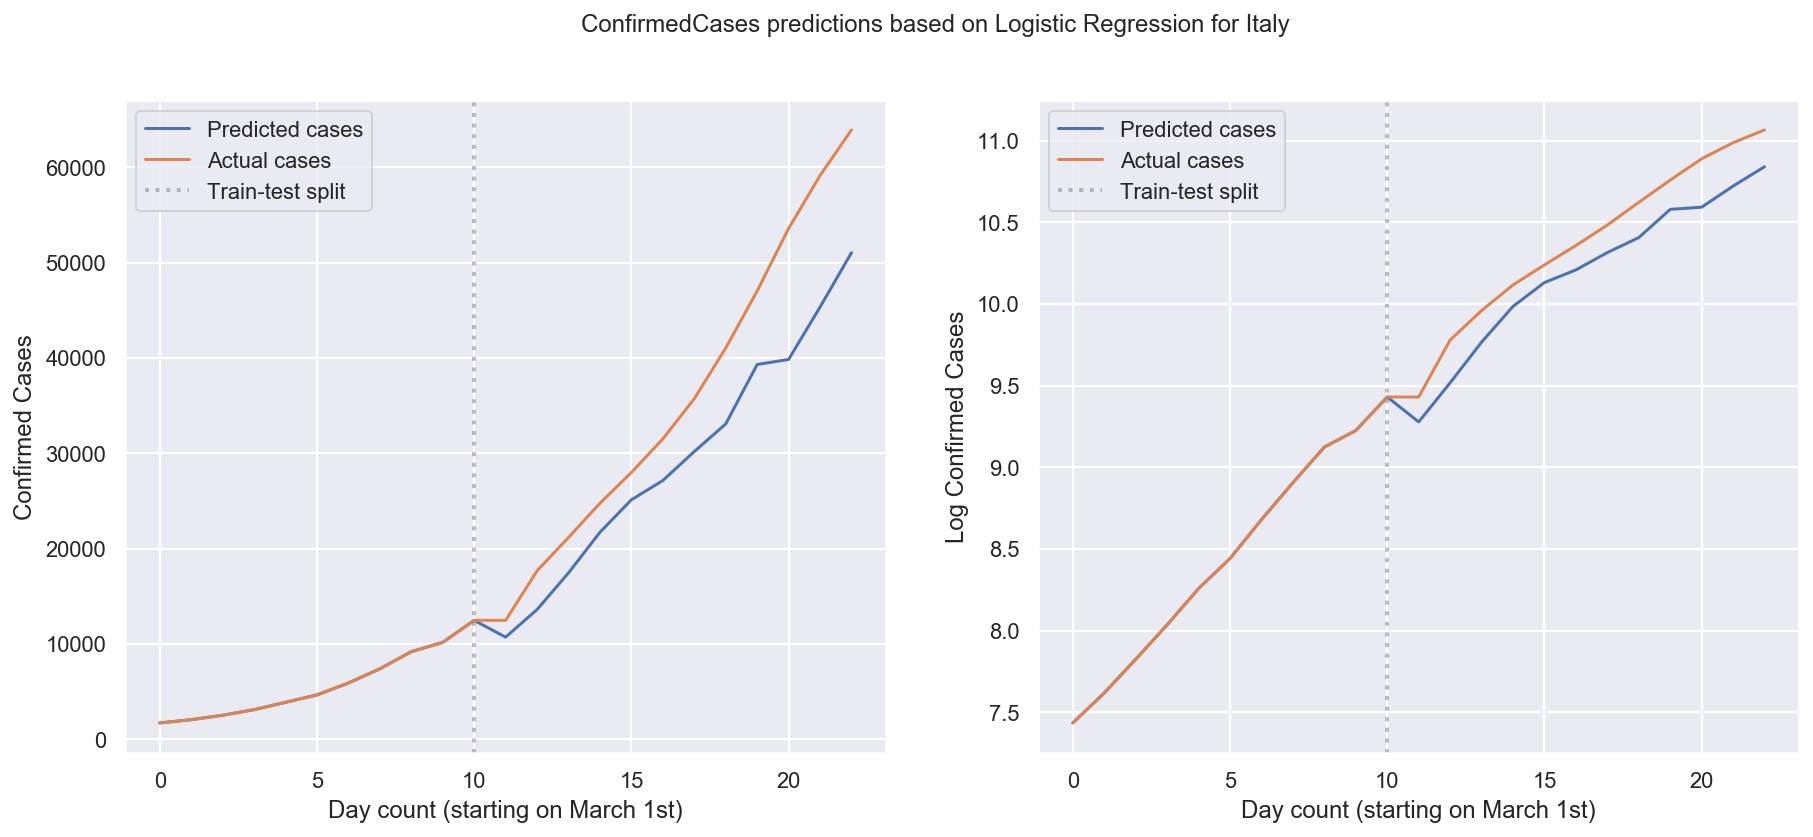

In [35]:
ts = time.time()

# Inputs
country_name = "Italy"
day_start = 35 
lag_size = 30

# Filter country and features from all_data (dataset without data leaking)
data = all_data.copy()
features = ['Id', 'Province/State', 'Country/Region', 'Lat', 'Long', 
       'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num', 'Day', 'Month',
       'Year', 'ConfirmedCases_1', 'ConfirmedCases_2', 'ConfirmedCases_3',
       'ConfirmedCases_4', 'ConfirmedCases_5', 'ConfirmedCases_6',
       'Fatalities_1', 'Fatalities_2', 'Fatalities_3', 'Fatalities_4',
       'Fatalities_5', 'Fatalities_6']
data = data[features]

# Select country an data start (all days)
data = data[data['Country/Region']==country_dict[country_name]]
data = data.loc[data['Day_num']>=day_start]

# Lags
data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
data = calculate_lag(data, range(1,lag_size), 'Fatalities')

# Apply log transformation
data[['ConfirmedCases', 'Fatalities', 'ConfirmedCases_1', 'ConfirmedCases_2', 'ConfirmedCases_3',
       'ConfirmedCases_4', 'ConfirmedCases_5', 'ConfirmedCases_6',
       'Fatalities_1', 'Fatalities_2', 'Fatalities_3', 'Fatalities_4',
       'Fatalities_5', 'Fatalities_6']] = data[['ConfirmedCases', 'Fatalities', 'ConfirmedCases_1', 'ConfirmedCases_2', 'ConfirmedCases_3',
       'ConfirmedCases_4', 'ConfirmedCases_5', 'ConfirmedCases_6',
       'Fatalities_1', 'Fatalities_2', 'Fatalities_3', 'Fatalities_4',
       'Fatalities_5', 'Fatalities_6']].apply(lambda x: np.log(x))
data.replace([np.inf, -np.inf], 0, inplace=True)
data.fillna(0, inplace=True)


# Start/end of forecast
start_fcst = all_data[all_data['Id']==-1].Day_num.min()
end_fcst = all_data[all_data['Id']==-1].Day_num.max()

for d in list(range(start_fcst, end_fcst+1)):
    X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d)
    model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
    data.loc[(data['Country/Region']==country_dict[country_name]) 
             & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
    model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
    data.loc[(data['Country/Region']==country_dict[country_name]) 
             & (data['Day_num']==d), 'Fatalities'] = pred_2[0]
    
    # Recompute lags 
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,lag_size), 'Fatalities')
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)
    
print("Process finished in ", round(time.time() - ts, 2), " seconds")


dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', 
                     '2020-03-10', '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                     '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23']
plot_real_vs_prediction_country(data, train, country_name, 39, dates_list)

In [36]:
ts = time.time()

# Set the dataframe where we will update the predictions
data_pred = data[data.ForecastId != -1][['Country/Region', 'Province/State', 'Day_num', 'ForecastId']]
data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
data_pred['Predicted_Fatalities'] = [0]*len(data_pred)
how_many_days = test.Date.nunique()
    
print("Currently running Logistic Regression with lags for all countries")

# Main loop for countries
for c in data['Country/Region'].unique():
    
    # List of provinces
    provinces_list = data2[data2['Country/Region']==c]['Province/State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        
        for p in provinces_list:
            # Only fit starting from the first confirmed case in the country
            train_countries_no0 = data.loc[(data['Country/Region']==c) & (data['Province/State']==p) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
            test_countries_no0 = data.loc[(data['Country/Region']==c) & (data['Province/State']==p) &  (data.ForecastId!=-1)]
            data2 = pd.concat([train_countries_no0, test_countries_no0])

            # If there are no previous cases, predict 0
            if len(train_countries_no0) == 0:
                data_pred.loc[((data_pred['Country/Region']==c) & (data_pred['Province/State']==p)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
                data_pred.loc[((data_pred['Country/Region']==c) & (data_pred['Province/State']==p)), 'Predicted_Fatalities'] = [0]*how_many_days
                
            # Else run LinReg
            else: 
                data_cp = data2[(data2['Country/Region']==c) & (data2['Province/State']==p)]
                X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp)
                model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
                model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
                data_pred.loc[((data_pred['Country/Region']==c) & (data2['Province/State']==p)), 'Predicted_ConfirmedCases'] = pred_1
                data_pred.loc[((data_pred['Country/Region']==c) & (data2['Province/State']==p)), 'Predicted_Fatalities'] = pred_2

    # No Province/State informed
    else:
        # Only fit starting from the first confirmed case in the country
        train_countries_no0 = data.loc[(data['Country/Region']==c) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
        test_countries_no0 = data.loc[(data['Country/Region']==c) &  (data.ForecastId!=-1)]
        data2 = pd.concat([train_countries_no0, test_countries_no0])

        # If there are no previous cases, predict 0
        if len(train_countries_no0) == 0:
            data_pred.loc[((data_pred['Country/Region']==c)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
            data_pred.loc[((data_pred['Country/Region']==c)), 'Predicted_Fatalities'] = [0]*how_many_days
        
        # Else, run LinReg
        else:
            data_c = data2[(data2['Country/Region']==c)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_c)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred.loc[(data_pred['Country/Region']==c), 'Predicted_ConfirmedCases'] = pred_1
            data_pred.loc[(data_pred['Country/Region']==c), 'Predicted_Fatalities'] = pred_2

# Aplly exponential transf. and clean potential infinites due to final numerical precision
data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.exp(x))
data_pred.replace([np.inf, -np.inf], 0, inplace=True) 

#get_submission(index, data_pred_2)

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Currently running Logistic Regression with lags for all countries
Process finished in  0.1  seconds
